# DCGAN
### This notebook contains an implementation of the model described [here](https://arxiv.org/abs/1511.06434)

## Notebook resources

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')
  

Thu Oct 27 18:52:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Defining constants

In [3]:
len_seed = 100 # How many elements in seed vector, 100 was used in DCGAN paper

## Loading and preprocessing MNIST

### Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

### Loading data

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

training_data = np.concatenate((X_train, X_test))

print(f'training_data shape: {training_data.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

11490434/11490434 [==============================] - 0s 0us/step
training_data shape: (70000, 28, 28)
X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


### Preprocessing


* Reshape the dataset to (70000, 28, 28, 1)
 * 70,000 images with a size of 28x28 and 1 color channel



In [7]:
training_data = training_data / 127.5 - 1 # Scale image pixels to [-1, 1]
training_data = np.reshape(training_data, (-1, 28, 28, 1))
np.random.shuffle(training_data) # Randomize order of images
training_data.shape

(70000, 28, 28, 1)

### Training image preview

In [8]:
def display_images(images):
  # Max number of images is 24
  if len(images) > 24:
    return

  fig = plt.figure(figsize=(8,8))
  columns = 6
  rows = 4
  for i in range(len(images)):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(images[i].reshape(28,28))

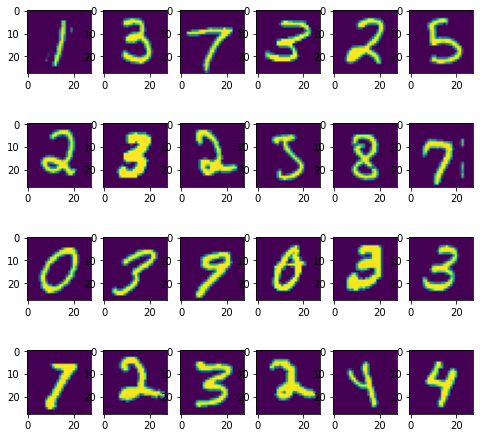

In [9]:
display_images(training_data[:24])

## Imports for building models

In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, UpSampling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, LeakyReLU, BatchNormalization, ZeroPadding2D

## Model Utils

In [11]:
def get_dcgan_specs(width, height):
    '''
    num_hidden_conv_layers:
        Equal to number of times we can evenly divide the width and height by 2.
        This is done this way since we use upsampling in each hidden layer which
        doubles the width and height.

    initial_num_filters 
        Derived from num_hidden_conv_layers. The goal is to have 128 filters in
        the last hidden layer. Since we halve the number of filters each time we
        upsample (as we do in each hidden conv layer) we can calculate the
        initial number of filters by taking 128 and doubling it for each hidden
        conv layer.
    '''

    num_hidden_conv_layers = 0
    while width > 4 and height > 4:
        width = width / 2
        height = height / 2
        if width.is_integer() and height.is_integer():
            num_hidden_conv_layers += 1
        else:
            break
    
    initial_width = width * 2
    initial_height = height * 2

    initial_num_filters = 128 * (2**num_hidden_conv_layers)
    
    specs = {
        'num_hidden_conv_layers': int(num_hidden_conv_layers),
        'initial_width': int(initial_width),
        'initial_height': int(initial_height),
        'initial_num_filters': int(initial_num_filters)
    }


    return specs

## Building toy model

In [ ]:
def build_generator(output_width, output_height, num_color_channels):
    print(num_color_channels)
    generator = Sequential([
      Dense(7*7*256, activation='relu',input_dim=len_seed), # Initial flat hidden layer
      Reshape((7, 7, 256)), # Reshape to 7x7x256 i.e. a 7x7 image with 256 filters

      UpSampling2D(), # Doubles the resolution of the representation (from 7x7x256 to 14x14x256)
      Conv2D(256, kernel_size=3, padding='same', activation='relu'),

      UpSampling2D(), # 28x28x128
      Conv2D(128, kernel_size=3, padding='same', activation='relu'),

      Conv2D(num_color_channels, kernel_size=3, padding='same') # Combine/Process 128 filters into 1 color channel
    ])

    return generator

def build_discriminator():
  image_shape = (28, 28, 1)

  discriminator = Sequential([
    Conv2D(32, kernel_size=3, input_shape=image_shape, padding='same', activation='relu'),
    Conv2D(64, kernel_size=3, padding='same', activation='relu'),
    Conv2D(128, kernel_size=3, padding='same', activation='relu'),
    Conv2D(256, kernel_size=3, padding='same', activation='relu'),
    Conv2D(512, kernel_size=3, padding='same', activation='relu'),
    Flatten(),
    Dense(1, activation='sigmoid')
  ])

  return discriminator

## Building DCGAN model

In [43]:
# weight initializer for all layers as suggested in the paper 
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)

def build_generator(output_width, output_height, num_color_channels):
  specs = get_dcgan_specs(output_width, output_height)

  input_layers = [
    Input(shape=(len_seed,)),
    Dense(
      specs['initial_width'] * specs['initial_height'] * specs['initial_num_filters'], 
      activation='relu', 
      kernel_initializer=weight_initializer
    ),
    Reshape((specs['initial_width'], specs['initial_height'], specs['initial_num_filters']))
  ]

  hidden_convolutional_layers = []
  for i in range(specs['num_hidden_conv_layers']):
    layers = [
      Conv2DTranspose(
        # Input layer has initial_num_filters, each hidden layer has half the
        # number of filters of the previous hidden layer
        specs['initial_num_filters'] // (2**(i + 1)), 
        kernel_size=3, 
        strides=2,
        padding='same', 
        activation='relu', 
        kernel_initializer=weight_initializer
      ),
      BatchNormalization(momentum=0.8)
    ]
    hidden_convolutional_layers.extend(layers)

  output_layers = [
    Conv2D(
      num_color_channels, 
      kernel_size=3, 
      padding='same', 
      activation='tanh', 
      kernel_initializer=weight_initializer
    )
  ]


  generator = Sequential(input_layers + hidden_convolutional_layers + output_layers)
  
  return generator
  
def build_discriminator(input_width, input_height, num_color_channels):
  specs = get_dcgan_specs(input_width, input_height)
  initial_num_filters = 64

  input_layers = [
    Input(shape=(input_width, input_height, num_color_channels)),
    Conv2D(
      initial_num_filters, 
      kernel_size=3, 
      strides=2, 
      padding='same'
    ),
    LeakyReLU(0.2),
  ]

  hidden_layers = []
  for i in range(specs['num_hidden_conv_layers'] - 1):
    layers = [
      Conv2D(
        initial_num_filters * (2**(i + 1)),
        kernel_size=3, 
        strides=2, 
        padding='same'
      ),
      LeakyReLU(0.2)
    ]
    hidden_layers.extend(layers)

  output_layers = [
    Flatten(),
    Dense(1, activation='sigmoid')
  ]

  discriminator = Sequential(input_layers + hidden_layers + output_layers)

  return discriminator



## Initialize GAN

In [44]:
generator = build_generator(28, 28, 1)
discriminator = build_discriminator(28, 28, 1)

## Test Generator output

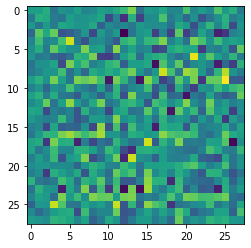

In [45]:
input_noise = tf.random.normal([1, len_seed])
generated_image = generator(input_noise, training=False)
generated_image = ((generated_image + 1) * 127.5) 
# generated_image
plt.imshow(tf.reshape(generated_image, (28, 28)))

## Test Discriminator output

In [46]:
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00929645]], dtype=float32)>

## Model summaries

### Generator summary

In [47]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 25088)             125440    
                                                                 
 reshape_3 (Reshape)         (None, 7, 7, 512)         0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 14, 14, 256)      1179904   
 ranspose)                                                       
                                                                 
 batch_normalization_6 (Batc  (None, 14, 14, 256)      1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                      

### Discriminator summary

In [48]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 flatten_3 (Flatten)         (None, 6272)              0         
                                                                 
 dense_7 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 80,769
Trainable params: 80,769
Non-trai

## Loss Functions

### Imports

In [29]:
from typing import BinaryIO
from tensorflow.keras.losses import BinaryCrossentropy

### Generator loss

In [30]:
binary_cross_entropy = BinaryCrossentropy(from_logits=True)

In [31]:
def generator_loss(y_pred_fake):
  return binary_cross_entropy(tf.ones_like(y_pred_fake), y_pred_fake)

### Discriminator loss

In [32]:
def discriminator_loss(y_pred_real, y_pred_fake):
  real_loss = binary_cross_entropy(tf.ones_like(y_pred_real), y_pred_real)
  fake_loss = binary_cross_entropy(tf.zeros_like(y_pred_fake), y_pred_fake)
  return real_loss + fake_loss

## Optimizers

### Imports

In [33]:
from tensorflow.keras.optimizers import Adam

### Generator optimizer

In [34]:
generator_optimizer = Adam(0.0002, 0.5) # Recommended values from DCGAN paper

### Discriminator optimizer

In [35]:
discriminator_optimizer = Adam(0.0002, 0.5)

## Set up checkpoint

In [36]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training function

### Imports

In [37]:
import time
from IPython import display

### Training function definitions

In [38]:
# @tf.function
def train_step(real_image_batch, batch_size):
  input_noise_seeds = tf.random.normal([batch_size, len_seed])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_image_batch = generator(input_noise_seeds, training=True)

    y_pred_real = discriminator(real_image_batch, training=True)
    y_pred_fake = discriminator(generated_image_batch, training=True)

    gen_loss = generator_loss(y_pred_fake)
    disc_loss = discriminator_loss(y_pred_real, y_pred_fake)

    print(f'Generator loss: {gen_loss}, Discriminator loss: {disc_loss}', end='\r')

    generator_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [39]:
def train(dataset, epochs, batch_size, num_test_seeds):
  if not (len(dataset) / batch_size).is_integer():
    print('Batch size not compatible with dataset size')
    return

  if num_test_seeds < 1:
    print('Number of test seeds invalid (must be > 0)')
    return
  
  test_seeds = tf.random.normal([num_test_seeds, len_seed])

  # Assumes that the dataset has already been preprocessed
  # Expected dataset shape (num_instances, width, height, color_channels)
  num_images = len(dataset)

  for epoch in range(epochs):
    
    start = time.time()
    gen_loss, disc_loss = None, None
    for i in range(len(dataset)//batch_size):
      display.clear_output(wait=True)
      real_image_batch = dataset[i * batch_size : (i + 1) * batch_size]
      print(f'Loss for previous batch #{i}: Generator loss = {gen_loss}, Discriminator loss = {disc_loss}')
      print(f'Epoch # {epoch + 1}/{epochs}')
      print(f'Batch # {i}/{len(dataset)//batch_size}')
      gen_loss, disc_loss = train_step(real_image_batch, batch_size)
      
    generate_and_save_images(generator, epoch + 1, test_seeds)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start} sec')
  
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, test_seeds)

In [40]:
def generate_and_save_images(model, epoch, test_seeds):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_seeds, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

## Training the model

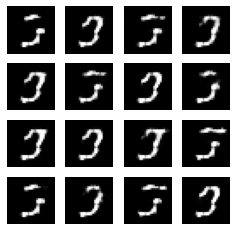

Total training time (in seconds): 533.8593356609344


In [42]:
start = time.time()
train(training_data, epochs=10, batch_size=125, num_test_seeds=16)
end = time.time()
print(f'Total training time (in seconds): {end - start}')

In [ ]:
training_data.shape

In [ ]:
generator.predict(tf.random.normal([4,]))

## Saving the model

In [ ]:
generator.save('./models/generator')

In [ ]:
discriminator.save('./models/discriminator')

## Download folder

In [ ]:
!tar cvf toy_model_batch_processing.tgz toy_model_batch_processing/

In [ ]:
!tar cvf generator.tgz ./models/generator